# Functional enrichment of biological terms

scRNA-seq yield many molecular readouts that are hard to interpret by themselves. One way of summarizing this information is by assigning them to biological terms from prior knowledge.

In this notebook we showcase how to use `decoupler` for functional enrichment with the 3k PBMCs 10X data-set. The data consists of 3k PBMCs from a Healthy Donor and is freely available
from 10x Genomics [here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz)
from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)

<div class="alert alert-info">

**Note**
    
This tutorial assumes that you already know the basics of `decoupler`. Else, check out the [Usage](https://decoupler-py.readthedocs.io/en/latest/notebooks/usage.html) tutorial first.

</div>

## Loading packages

First, we need to load the relevant packages, `scanpy` to handle scRNA-seq data
and `decoupler` to use statistical methods.

In [1]:
import scanpy as sc
import decoupler as dc

# Only needed for visualization:
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the data

We can download the data easily using `scanpy`:

In [2]:
adata = sc.datasets.pbmc3k_processed()
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

We can visualize the different cell types in it:

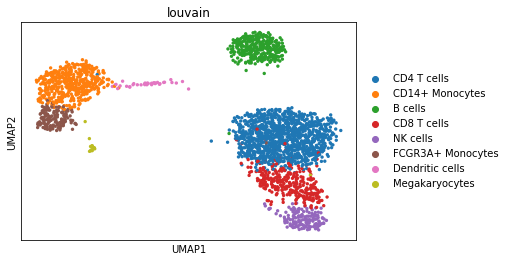

In [3]:
sc.pl.umap(adata, color='louvain')

## MSigDB gene sets

The Molecular Signatures Database ([MSigDB](http://www.gsea-msigdb.org/gsea/msigdb/)) is a resource containing a collection of gene sets annotated to different biological processes.

In [4]:
msigdb = dc.get_resource('MSigDB')
msigdb

,genesymbol,collection,geneset
0,MSC,oncogenic_signatures,PKCA_DN.V1_DN
1,MSC,mirna_targets,MIR12123
2,MSC,chemical_and_genetic_perturbations,NIKOLSKY_BREAST_CANCER_8Q12_Q22_AMPLICON
3,MSC,immunologic_signatures,GSE32986_UNSTIM_VS_GMCSF_AND_CURDLAN_LOWDOSE_S...
4,MSC,chemical_and_genetic_perturbations,BENPORATH_PRC2_TARGETS
...,...,...,...
2407729,OR2W5P,immunologic_signatures,GSE22601_DOUBLE_NEGATIVE_VS_CD8_SINGLE_POSITIV...
2407730,OR2W5P,immunologic_signatures,KANNAN_BLOOD_2012_2013_TIV_AGE_65PLS_REVACCINA...
2407731,OR52L2P,immunologic_signatures,GSE22342_CD11C_HIGH_VS_LOW_DECIDUAL_MACROPHAGE...
2407732,CSNK2A3,immunologic_signatures,OCONNOR_PBMC_MENVEO_ACWYVAX_AGE_30_70YO_7DY_AF...


As an example, we will use the hallmark gene sets, but we could have used any other. 

<div class="alert alert-info">

**Note**
    
To see what other collections are available in MSigDB, type: `msigdb['collection'].unique()`.

</div>  

We can filter by for `hallmark`:

In [5]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]
msigdb

,genesymbol,collection,geneset
11,MSC,hallmark,HALLMARK_TNFA_SIGNALING_VIA_NFKB
149,ICOSLG,hallmark,HALLMARK_TNFA_SIGNALING_VIA_NFKB
223,ICOSLG,hallmark,HALLMARK_INFLAMMATORY_RESPONSE
270,ICOSLG,hallmark,HALLMARK_ALLOGRAFT_REJECTION
398,FOSL2,hallmark,HALLMARK_HYPOXIA
...,...,...,...
878342,FOXO1,hallmark,HALLMARK_PANCREAS_BETA_CELLS
878418,GCG,hallmark,HALLMARK_PANCREAS_BETA_CELLS
878512,PDX1,hallmark,HALLMARK_PANCREAS_BETA_CELLS
878605,INS,hallmark,HALLMARK_PANCREAS_BETA_CELLS


For this example we will use the resource MSigDB, but we could have used any other such as GO. To see the list of available resources inside `Omnipath`, run `dc.show_resources()`

## Enrichment with Over Representation Analysis

To test if a gene set is enriched in a given cell, we will run
Over Representation Analysis (`ora`), also known as Fisher exact test, but we could 
do it with any of the other available methods in `decoupler`.

`ora` selects the top 5% expressed genes for each cell, and tests if a gene set is
enriched in the top (or bottom) expressed collection.

To run `decoupler` methods, we need an input matrix (`mat`), an input prior knowledge
network/resource (`net`), and the name of the columns of `net` that we want to use.

In [6]:
dc.run_ora(mat=adata, net=msigdb, source='geneset', target='genesymbol', verbose=True)

1 features of mat are empty, they will be removed.
Running ora on mat with 2638 samples and 13713 targets for 50 sources.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2638/2638 [00:02<00:00, 1088.99it/s]


The obtained scores (-log10(p-value))(`ora_estimate`) and p-values (`ora_pvals`) are stored in the `.obsm` key:

In [7]:
adata.obsm['ora_estimate']

source,HALLMARK_ADIPOGENESIS,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANGIOGENESIS,HALLMARK_APICAL_JUNCTION,HALLMARK_APICAL_SURFACE,HALLMARK_APOPTOSIS,HALLMARK_BILE_ACID_METABOLISM,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_COAGULATION,...,HALLMARK_PROTEIN_SECRETION,HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,HALLMARK_SPERMATOGENESIS,HALLMARK_TGF_BETA_SIGNALING,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UV_RESPONSE_DN,HALLMARK_UV_RESPONSE_UP,HALLMARK_WNT_BETA_CATENIN_SIGNALING,HALLMARK_XENOBIOTIC_METABOLISM
AAACATACAACCAC-1,1.307006,10.029702,0.822139,0.389675,1.670031,0.650245,2.441094,0.337563,0.805206,0.032740,...,0.733962,2.286568,0.354931,2.986336,8.220117,6.365243,0.586324,1.983873,0.164805,0.080157
AAACATTGAGCTAC-1,1.307006,14.824230,2.152116,0.389675,2.104104,-0.000000,0.442704,0.337563,0.457516,0.321093,...,2.496213,1.659624,1.015676,1.659624,3.027820,2.547763,0.346751,0.871448,0.503794,0.080157
AAACATTGATCAGC-1,3.893118,7.893567,3.312021,0.389675,3.095283,0.650245,5.115631,0.976973,0.805206,0.321093,...,1.087271,3.752012,0.037885,1.114303,7.549513,2.048977,0.888675,4.038435,0.164805,1.087420
AAACCGTGCTTCCG-1,5.591584,7.893567,2.152116,1.036748,1.670031,-0.000000,2.911700,0.143019,1.747025,0.591452,...,1.501986,3.752012,0.354931,1.659624,5.669689,4.950302,0.346751,1.567924,0.164805,1.087420
AAACCGTGTATGCG-1,0.999733,10.029702,2.707608,1.871866,1.670031,1.948869,0.666121,0.337563,0.805206,0.591452,...,1.973108,1.659624,0.151790,1.114303,1.785917,1.596582,0.586324,0.375221,0.164805,0.179270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,3.382339,9.297059,1.204403,1.036748,2.580035,0.224257,10.804691,0.143019,2.324194,1.359530,...,3.683543,3.752012,0.151790,2.286568,5.669689,2.048977,0.586324,4.639190,0.164805,1.087420
TTTCTACTGAGGCA-1,6.851412,4.777953,6.964458,1.036748,1.670031,0.650245,2.006125,0.035215,0.457516,1.359530,...,3.683543,1.659624,0.151790,2.286568,2.168128,8.718220,0.172992,2.441252,0.164805,0.080157
TTTCTACTTCCTCG-1,1.652714,7.224004,2.152116,-0.000000,1.670031,1.235034,2.441094,0.337563,1.238111,0.134773,...,1.087271,0.661862,0.151790,1.659624,8.911564,3.089847,0.064563,4.639190,-0.000000,0.329247
TTTGCATGAGAGGC-1,2.034899,5.352930,1.204403,1.036748,0.939005,1.235034,0.267770,0.617706,0.805206,0.134773,...,0.733962,2.286568,0.151790,0.661862,3.502378,5.641478,0.346751,2.441252,0.164805,0.329247


## Visualization

To visualize the obtianed scores, we can re-use many of `scanpy`'s plotting functions.
First though, we need to extract them from the `adata` object.

In [8]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')
acts

AnnData object with n_obs × n_vars = 2638 × 50
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'ora_estimate', 'ora_pvals'

`dc.get_acts` returns a new `AnnData` object which holds the obtained activities in its `.X` attribute, allowing us to re-use many `scanpy` functions, for example:

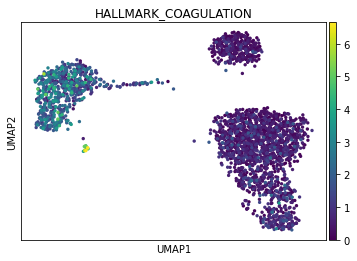

In [9]:
sc.pl.umap(acts, color='HALLMARK_COAGULATION')

The cells highlighted seem to be enriched by coagulation.

## Exploration

With `decoupler` we can also see what is the mean enrichment per group:

In [10]:
mean_enr = dc.summarize_acts(acts, groupby='louvain', min_std=1)
mean_enr

,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_APOPTOSIS,HALLMARK_COAGULATION,HALLMARK_COMPLEMENT,HALLMARK_HYPOXIA,HALLMARK_INTERFERON_ALPHA_RESPONSE,HALLMARK_INTERFERON_GAMMA_RESPONSE,HALLMARK_MYC_TARGETS_V1,HALLMARK_OXIDATIVE_PHOSPHORYLATION,HALLMARK_TNFA_SIGNALING_VIA_NFKB
B cells,8.354994,1.917664,0.290295,1.229005,4.229028,5.219356,7.148639,18.921244,7.434455,3.780326
CD14+ Monocytes,7.548974,4.732542,1.753238,6.105103,5.718626,6.597623,9.203345,15.001544,10.768515,6.447618
CD4 T cells,7.367119,2.989820,0.404844,1.667583,5.704934,5.119762,5.761981,20.898235,8.849491,4.792259
CD8 T cells,10.050341,2.916126,0.551194,3.018337,5.510883,5.461279,7.221680,19.887226,8.511161,4.978559
Dendritic cells,11.001875,4.818395,1.361634,4.210152,6.341395,8.200227,11.063760,25.464518,15.929270,6.571718
FCGR3A+ Monocytes,9.142790,4.914899,2.015463,7.896366,6.478059,9.304629,11.687559,17.928917,13.115271,5.791608
Megakaryocytes,4.484497,3.401895,4.256961,3.466092,2.935619,1.846708,1.656383,5.570364,5.332106,3.127663
NK cells,10.658255,2.931217,0.644769,3.999646,5.708977,7.291569,9.032887,18.066849,8.723539,3.751579


We can visualize which group is more enriched using `seaborn`:

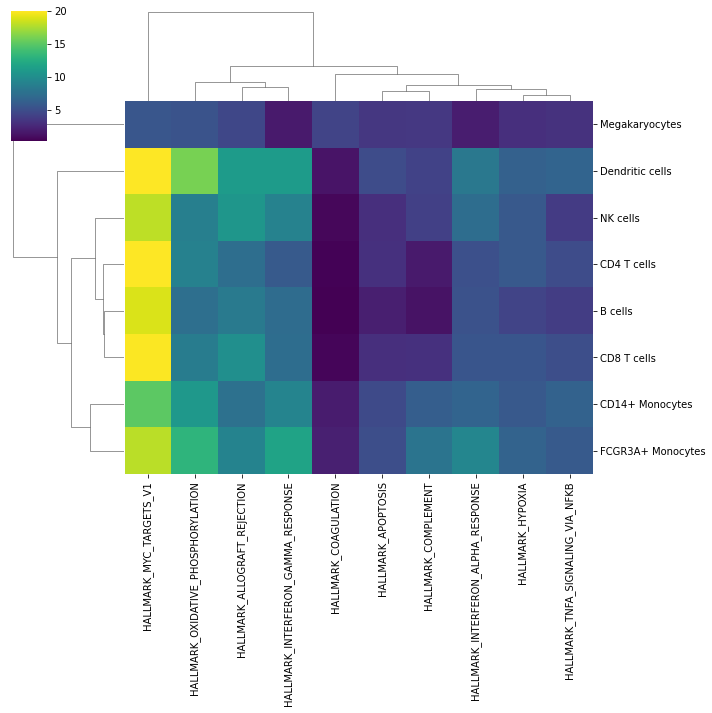

In [11]:
sns.clustermap(mean_enr, xticklabels=mean_enr.columns, vmax=20, cmap='viridis')
plt.show()

In this specific example, we can observe that most cell types are enriched by targets of MYC, a global regulator of the immune system, and megakaryocytes are enriched by coagulation genes.

<div class="alert alert-info">

**Note**
    
If your data consist of different conditions with enough samples, we recommend to work with pseudo-bulk profiles instead. Check this
[vignette](https://decoupler-py.readthedocs.io/en/latest/notebooks/pseudobulk.html) for more informatin.

</div>